<a href="https://colab.research.google.com/github/haosulab/ManiSkill2/blob/tutorials/examples/tutorials/1_quickstart_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ManiSkill2 Tutorial: Quickstart

This tutorial includes:
- create a gym-style ManiSkill2 environment
- replay and convert demonstrations

**The tutorial needs a GPU runtime.** The simulation backend of [ManiSkill2](https://github.com/haosulab/ManiSkill2) is [SAPIEN](https://sapien.ucsd.edu/).

In [ ]:
# @title Install ManiSkill2 (for Colab)

# TODO: change branch to main
!apt-get install -y --no-install-recommends libvulkan-dev
!pip install "setuptools>=62.3.0"
!pip install -v git+https://github.com/haosulab/ManiSkill2.git@tutorials
# !git clone -b tutorials https://github.com/haosulab/ManiSkill2.git --single-branch --depth 1
# %cd /content/ManiSkill2
# !pip install .
!pip uninstall -y pathlib  # avoid overriding the builtin one
# TODO: remove when we have released sapien
!pip uninstall -y sapien && pip install https://anaconda.org/jigu/sapien/2.0.0.dev20230112/download/sapien-2.0.0.dev20230112-cp38-cp38-manylinux2014_x86_64.whl

## Create an environment

ManiSkill2 follows the interface of [OpenAI Gym](https://github.com/openai/gym). Each environment supports different **observation modes** and **control modes**, which determine the **observation space** and **action space**. Some environments require downloading assets first. In this tutorial, we will focus on environments without extra assets.

In [1]:
%matplotlib inline 

import sys

import gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Register ManiSkill2 environments in gym
import mani_skill2.envs

np.set_printoptions(suppress=True, precision=3)
IN_COLAB = "google.colab" in sys.modules

In [2]:
# Make observation space repr more readable (for gym>0.18.3,<0.22.0)
from gym import spaces


def _gym_spaces_Box_repr(self: spaces.Box):
    """A workaround for gym>0.18.3"""
    return f"Box({self.low.min()}, {self.high.max()}, {self.shape}, {self.dtype})"


spaces.Box.__repr__ = _gym_spaces_Box_repr


In [3]:
#@title Choose an environment id, observation mode, control mode, and reward mode

# TODO: update the link to docs
# See <> for all environment ids
env_id = "PickCube-v0" #@param ['PickCube-v0', 'PegInsertionSide-v0', 'StackCube-v0', 'PlugCharger-v0']

# Choose an observation mode. See <> for details.
obs_mode = "rgbd" #@param ['pointcloud', 'rgbd', 'state_dict', 'state']

# Choose a controller mode (action space). See <> for details.
control_mode = "pd_joint_delta_pos" #@param ['pd_ee_delta_pose', 'pd_ee_delta_pos', 'pd_joint_delta_pos', 'arm_pd_joint_pos_vel']

reward_mode = "dense" #@param ['sparse', 'dense']

Observation space: Dict(agent:Dict(base_pose:Box(-inf, inf, (7,), float32), controller:Dict(arm:Dict(), gripper:Dict()), qpos:Box(-inf, inf, (9,), float32), qvel:Box(-inf, inf, (9,), float32)), camera_param:Dict(base_camera:Dict(cam2world:Box(-inf, inf, (4, 4), float32), intrinsic:Box(-inf, inf, (3, 3), float32)), hand_camera:Dict(cam2world:Box(-inf, inf, (4, 4), float32), intrinsic:Box(-inf, inf, (3, 3), float32))), extra:Dict(goal_pos:Box(-inf, inf, (3,), float64), tcp_pose:Box(-inf, inf, (7,), float32)), image:Dict(base_camera:Dict(rgb:Box(0, 255, (128, 128, 3), uint8), depth:Box(0.0, inf, (128, 128, 1), float32)), hand_camera:Dict(rgb:Box(0, 255, (128, 128, 3), uint8), depth:Box(0.0, inf, (128, 128, 1), float32))))
Action space: Box(-1.0, 1.0, (8,), float32)


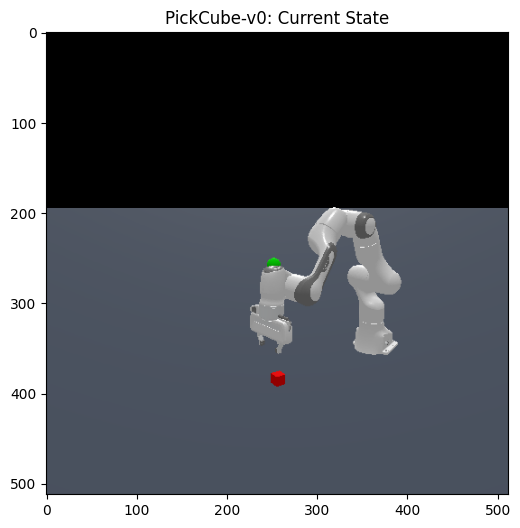

In [4]:
# Create an environment
env = gym.make(env_id, obs_mode=obs_mode, control_mode=control_mode, reward_mode=reward_mode)
obs = env.reset()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# Render
img = env.render(mode="rgb_array")
plt.figure(figsize=(10,6))
plt.title(f"{env_id}: Current State")
plt.imshow(img)

# Close the environment
env.close()
del env

In [5]:
# Utilities to visualize observation

def show_rgbd(camera_obs, title=None):
    plt.figure()
    rgb, depth = camera_obs['rgb'], camera_obs['depth']
    plt.subplot(1,2,1)
    plt.title(f"{title} - RGB")
    plt.imshow(camera_obs['rgb'])
    plt.subplot(1,2,2)
    plt.title(f"{title} - Depth")
    plt.imshow(camera_obs['depth'][..., 0], cmap="gray")

  
def show_pointcloud(obs):
    import trimesh
    xyzw = obs['pointcloud']['xyzw']  # [N, 4]
    mask = xyzw[:, -1] > 0
    v = xyzw[mask, :3]
    rgb = obs['pointcloud']['rgb'][mask]
    pcd = trimesh.points.PointCloud(v, rgb)
    scene = trimesh.Scene([pcd])
    return scene.show("notebook")

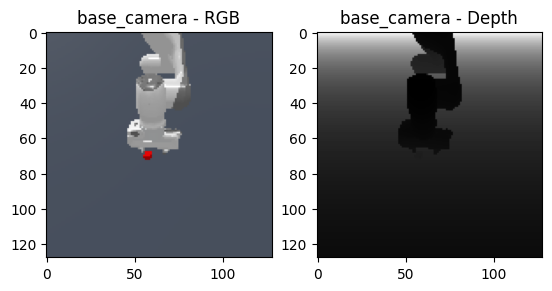

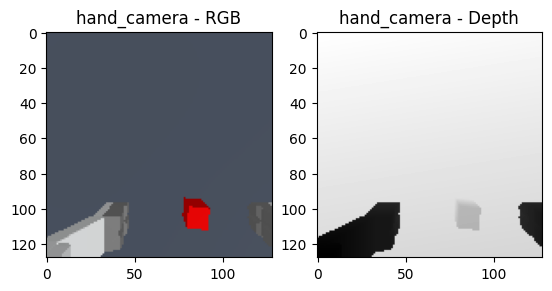

In [6]:
# Visualize rgbd observation
if obs_mode == "rgbd":
    for camera_name in obs["image"]:
        show_rgbd(obs["image"][camera_name], camera_name)

In [9]:
# Visualize pointcloud observation
if obs_mode == "pointcloud":
    from IPython.display import display
    display(show_pointcloud(obs))

### Record an episode with random actions

We provide a wrapper `RecordEpisode` to help record trajectories (HDF5 and json) and videos (mp4) of episodes. Note that this wrapper adds some overhead so please avoid using it for cases like RL training.

ManiSkill2 also has an interactive viewer, available if you have a GUI. You can render the current state with `env.render()` which will bring up a viewer.

In [7]:
import numpy as np
from mani_skill2.utils.wrappers import RecordEpisode

# Render mode passed to `env.render`.
# 'rgb_array' - images from cameras for rendering only
# 'cameras' - images from all cameras (both cameras for rendering and task)
# 'human' - render in a GL window if with display
render_mode = "cameras"  # @param can be one of ['cameras', 'rgb_array']

env = gym.make(env_id)
env = RecordEpisode(
    env,
    "./tmp",  # the output directory to save trajectories and videos
    save_trajectory=True,
    trajectory_name="trajectory",  # the name of the trajectory file. If None, will use timestamp.
    save_video=True,
    render_mode=render_mode,
    info_on_video=True,  # when True, will add informative text onto the replay video such as step counter, reward, and other metrics
)

# Step through the environment with random actions
obs = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    # env.render() # render in a GL window if with display

# `RecordEpisode` will automatically flush trajectories and videos when closed.
# You can also manually flush them.
# env.flush_trajectory()
# env.flush_video()
env.close()
del env

from IPython.display import Video
Video("./tmp/0.mp4", embed=True)  # Watch our replay

  0%|          | 0/100 [00:00<?, ?it/s]

## Use demonstrations

The following section will go through the basic usage of the ManiSkill2 demonstration dataset.

Each environment comes with one or multiple `.h5` files composed of demonstration trajectories. Moreover, each `.h5` file has an associated `.json` file which defines the environment configuration of those demonstrations.

In [ ]:
# @title Download a demo
# We provide a command line tool to download demonstrations.
!python -m mani_skill2.utils.download_demo {env_id} -o "demos"

### Load demonstrations

In [8]:
import h5py
from mani_skill2.utils.io_utils import load_json

# Load the trajectory data from the .h5 file
traj_path = f"demos/rigid_body/{env_id}/trajectory.h5"
# You can also replace the above path with the trajectory you just recorded (./tmp/trajectory.h5)
h5_file = h5py.File(traj_path, "r")

# Load associated json
json_path = traj_path.replace(".h5", ".json")
json_data = load_json(json_path)

episodes = json_data["episodes"]  # meta data of each episode
env_info = json_data["env_info"]
env_id = env_info["env_id"]
env_kwargs = env_info["env_kwargs"]

print("env_id:", env_id)
print("env_kwargs:", env_kwargs)
print("#episodes:", len(episodes))

env_id: PickCube-v0
env_kwargs: {'obs_mode': 'none', 'control_mode': 'pd_joint_pos'}
#episodes: 1000


The trajectory of each episode is stored under the `traj_{episode_id}` key in the HDF5 file. `episode_id` usually ranges from 0 to `len(episodes) - 1`.
`episode_id` and other meta information of episdoes are stored under the `episodes` key in the JSON file.
The raw trajectory contains 3 keys: `actions`, `env_states` and `success`. For soft-body environments, `env_states` is replaced by `env_init_state` (initial state) to reduce data storage.

In [9]:
traj_id = "traj_0"
traj_h5 = h5_file[traj_id]
for key in traj_h5:
    print(key, traj_h5[key].shape, traj_h5[key].dtype)

actions (88, 8) float32
env_states (89, 73) float32
success (88,) bool


**Notably, the raw trajectories do not include actual observations.** We store both actions and environment states, which can be used to replay trajectories and generate desired observations (states, RGBD images, point cloud). Please see the following sections for how to replay and convert demonstrations to your desired observation and action spaces.

### Replay demonstrations

To replay the trajectory of an episode, you need to first create an environment given the environment initialization keyword arguments stored in the JSON file. Besides, you need to reset the environment with the same seed and other keyword arguments of the episode recorded in the JSON file. Then, the trajectory can be replayed by actions or environment states stored in the HDF5 file.

In [10]:
def replay(episode_idx, h5_file, json_data, render_mode="cameras", fps=20):
    episodes = json_data["episodes"]
    ep = episodes[episode_idx]
    # episode_id should be the same as episode_idx, unless specified otherwise
    episode_id = ep["episode_id"]
    traj = h5_file[f"traj_{episode_id}"]

    # Create the environment
    env_kwargs = json_data["env_info"]["env_kwargs"]
    env = gym.make(env_id, **env_kwargs)
    # Reset the environment
    reset_kwargs = ep["reset_kwargs"].copy()
    reset_kwargs["seed"] = ep["episode_seed"]
    env.reset(**reset_kwargs)

    frames = [env.render(mode=render_mode)]

    for i in tqdm(range(len(traj["actions"]))):
        action = traj["actions"][i]
        obs, reward, done, info = env.step(action)
        # env.render()
        frames.append(env.render(mode=render_mode))
    
    env.close()
    del env
    return frames

In [11]:
from mani_skill2.utils.visualization.jupyter_utils import display_images

episode_idx = 0 #@param {type:"integer"}
frames = replay(episode_idx, h5_file, json_data)
display_images(frames, format="jshtml",  repeat=True, cache_frame_data=False, interval=50)

  0%|          | 0/88 [00:00<?, ?it/s]

### Convert demonstrations

The demonstration dataset does not include actual observations. You can convert trajectories to the desired observation space and action space. We provide a tool to help replay and convert trajectories.

```python
# Replay the trajectory to `rgbd` observations and the `pd_ee_delta_pose` controller with 10 processes in parallel
python -m mani_skill2.trajectory.replay_trajectory --traj-path demos/rigid_body/PickCube-v0/trajectory.h5 --save-traj --obs-mode rgbd --target-control-mode pd_ee_delta_pose --num-procs 10
```